In [1]:
import glob
import time
import warnings  
import datetime
import numpy as np
import pandas as pd
import pmdarima as pm
from numpy import log
import statsmodels.api as sm
import matplotlib.pyplot as plt
from bokeh.layouts import gridplot
from statsmodels.tsa.api import VAR
from bokeh.palettes import Spectral3
from bokeh.io import output_notebook
from pmdarima.arima.utils import ndiffs
from bokeh.models import ColumnDataSource
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.compat.pandas import Appender
from bokeh.plotting import figure, output_file, show
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller #Fuller test for stationary check

warnings.filterwarnings('ignore')

In [2]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [3]:
output_notebook() #Where output will be shown

Loading BokehJS ...

In [4]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test

def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

In [5]:
# Cointegration Test
### Cointegration test helps to establish the presence of a statistically 
### significant connection between two or more time series

def adjust(val, length= 6): return str(val).ljust(length)

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
        

In [6]:
# inverting transformation


def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


In [7]:
#Function to Evaluate the Forecasts

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [8]:
def get_order_of_differencing(df):

    ## Adf Test to check the order of differencing required
    
    all_cols = df.columns.to_list()
    
    column_count = 0
    column_sum = 0
    for cols in all_cols:
        column_sum = column_sum + ndiffs(df[cols], test='adf')
        column_count = column_count + 1
    
    return round(column_sum/column_count)
    

In [9]:
def get_differenced_df(df, d):
    
    diff_df = df.copy()
    for i in range(0,d):
        diff_df = diff_df.diff().dropna()
    
    return diff_df

In [10]:
def model_forecast(df, country, class_):
    
    index_of_fc = pd.date_range('2018-01-01', periods=3, freq='YS')
    
    temp_df = df[df['CountryName'] == country]
    temp_df = temp_df[temp_df['Class'] == class_]
    temp_df.drop(columns=['CountryName', 'Class', 'Zone'], inplace=True)
    temp_df['MortalityYear'] = pd.to_datetime(temp_df['MortalityYear'], format='%Y')
    temp_df = temp_df.set_index('MortalityYear')
    
    d = get_order_of_differencing(temp_df)
    diff_df = get_differenced_df(temp_df, d)
    
    suffix = '_' + str(d) + 'd'
    for cols in diff_df.columns.to_list():
        diff_df.rename(columns={cols: cols+suffix}, inplace=True)
    
    # model fitting
    model = VAR(diff_df)
    results = model.fit()
    
    #Forecast
    pred = results.forecast(results.y, steps=3)
    df_forecast = pd.DataFrame(pred, index=index_of_fc, columns=diff_df.columns) #convert into df
    
    if d == 1:
        second_diff = False
    elif d == 2:
        second_diff = True
             
    df_results = invert_transformation(temp_df, df_forecast, second_diff=second_diff) 
    df_results = df_results.loc[:, ['Deaths_forecast', 'GDP_forecast', 'Health_Expenditure_forecast', 'Number_of_Physicians_per1000_people_forecast', 'Population_forecast']]
    df_results.rename(columns={"Deaths_forecast": "Deaths", "GDP_forecast": "GDP", 
                               "Health_Expenditure_forecast" : "Health_Expenditure", 
                               "Number_of_Physicians_per1000_people_forecast" : "Number_of_Physicians_per1000_people", 
                               "Population_forecast" : "Population"}, inplace=True)
    
    final = temp_df.append(df_results).reset_index(drop=False)

    return final


In [11]:
def plot_countries(final): 

    glyph_list = []
    countries = list(final.CountryName.unique())
    
    for c in countries:
        country_df = final[final['CountryName'] == c]
        country_name = str(country_df.CountryName.unique())
        country_df = country_df[['Year', 'Deaths']]
        country_df.reset_index(drop=True, inplace=True)
    
        actual = country_df[:-3]
        gap = actual[-1:]
        forecast = gap.append(country_df[-3:]).reset_index(drop=True)

        source = ColumnDataSource(actual) 
        p = figure(x_axis_type='datetime', title=country_name)
        p.line(x='Year', y='Deaths', line_width=2, source=source, legend='Actual')

        source = ColumnDataSource(forecast)
        p.line(x='Year', y='Deaths', line_width=2, source=source, color='red', legend='Forecast')

        glyph_list.append(p)
        
    return glyph_list

#### Reading the data

In [12]:
df = pd.read_csv("Dataset_For_Prediction.csv")#index_col="MortalityYear", parse_dates=True)
print(df.shape, "\n")
print(df.info())
df.head(5)

(392, 9) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
CountryName                            392 non-null object
MortalityYear                          392 non-null int64
Class                                  392 non-null object
Deaths                                 392 non-null int64
GDP                                    392 non-null float64
Health_Expenditure                     392 non-null float64
Number_of_Physicians_per1000_people    392 non-null float64
Population                             392 non-null float64
Zone                                   392 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 27.6+ KB
None


,CountryName,MortalityYear,Class,Deaths,GDP,Health_Expenditure,Number_of_Physicians_per1000_people,Population,Zone
0,Argentina,1997,Bronchitis,282,8543.028534,450.225150,2.839366,35657429.0,SouthAmerica
1,Argentina,1997,Tuberculosis,144,8543.028534,450.225150,2.839366,35657429.0,SouthAmerica
2,Argentina,1998,Bronchitis,282,8772.063210,478.268474,3.002100,36063459.0,SouthAmerica
3,Argentina,1998,Tuberculosis,127,8772.063210,478.268474,3.002100,36063459.0,SouthAmerica
4,Argentina,1999,Bronchitis,314,8381.253998,437.328304,2.834859,36467218.0,SouthAmerica


In [13]:
print("Unique Countries: ", df.CountryName.nunique())
print(df.CountryName.unique())
print("\nAll years: ", df.MortalityYear.nunique())
print(df.MortalityYear.unique())
print("\nDifferent Zones: ", df.Zone.nunique())
print(df.Zone.unique())

Unique Countries:  10
['Argentina' 'Brazil' 'Canada' 'Colombia' 'Cuba' 'Ecuador' 'Mexico' 'Peru'
 'Puerto Rico' 'United States']

All years:  22
[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 1996]

Different Zones:  4
['SouthAmerica' 'NorthernAmerica' 'Caribbean' 'CentralAmerica']


## Bronchitis - A sample

In [14]:
br = df[df['Class'] == 'Bronchitis']
print("Shape: ", br.shape)
print("\nDifferent Countries: ",br.CountryName.nunique(), "\n", br.CountryName.unique())
br.head()

Shape:  (197, 9)

Different Countries:  10 
 ['Argentina' 'Brazil' 'Canada' 'Colombia' 'Cuba' 'Ecuador' 'Mexico' 'Peru'
 'Puerto Rico' 'United States']


,CountryName,MortalityYear,Class,Deaths,GDP,Health_Expenditure,Number_of_Physicians_per1000_people,Population,Zone
0,Argentina,1997,Bronchitis,282,8543.028534,450.225150,2.839366,35657429.0,SouthAmerica
2,Argentina,1998,Bronchitis,282,8772.063210,478.268474,3.002100,36063459.0,SouthAmerica
4,Argentina,1999,Bronchitis,314,8381.253998,437.328304,2.834859,36467218.0,SouthAmerica
6,Argentina,2000,Bronchitis,217,8224.112827,705.199321,3.042454,36870787.0,SouthAmerica
8,Argentina,2001,Bronchitis,262,7776.137872,671.529439,3.231100,37275652.0,SouthAmerica


In [15]:
#Checking for null values
br.columns.isna()

array([False, False, False, False, False, False, False, False, False])

In [16]:
#A sample of what is done in the functions

c = 'Argentina'

s = br[br['CountryName'] == c]
s.drop(columns=['CountryName', 'Class', 'Zone'], inplace=True)
s['MortalityYear'] = pd.to_datetime(s['MortalityYear'], format='%Y')
s = s.set_index('MortalityYear')
s

,Deaths,GDP,Health_Expenditure,Number_of_Physicians_per1000_people,Population
MortalityYear,,,,,
1997-01-01,282,8543.028534,450.225150,2.839366,35657429.0
1998-01-01,282,8772.063210,478.268474,3.002100,36063459.0
1999-01-01,314,8381.253998,437.328304,2.834859,36467218.0
2000-01-01,217,8224.112827,705.199321,3.042454,36870787.0
2001-01-01,262,7776.137872,671.529439,3.231100,37275652.0
2002-01-01,217,6854.294081,223.379708,2.785163,37681749.0
2003-01-01,245,7380.467087,261.489665,2.767959,38087868.0
2004-01-01,200,7962.412309,299.627944,3.166200,38491972.0
2005-01-01,197,8577.864994,390.991101,3.210000,38892931.0


In [17]:
nobs = 4
s_train, s_test = s[0:-nobs], s[-nobs:]
print("Training shape: ",s_train.shape)
print("Testing shape: ",s_test.shape)

Training shape:  (17, 5)
Testing shape:  (4, 5)


In [18]:
#apply adf test on the series
adf_test(s_train["Deaths"])
adf_test(s_train["GDP"])
adf_test(s_train["Health_Expenditure"])
adf_test(s_train["Number_of_Physicians_per1000_people"])
adf_test(s_train["Population"])

Test Statistic          -0.835509
p-value                  0.808468
# Lags                   5.000000
# Observations          11.000000
Critical Value (1%)     -4.223238
Critical Value (5%)     -3.189369
Critical Value (10%)    -2.729839
dtype: float64
 Series is Non-Stationary
Test Statistic          -0.307393
p-value                  0.924451
# Lags                   0.000000
# Observations          16.000000
Critical Value (1%)     -3.924019
Critical Value (5%)     -3.068498
Critical Value (10%)    -2.673893
dtype: float64
 Series is Non-Stationary
Test Statistic          -0.086447
p-value                  0.950772
# Lags                   0.000000
# Observations          16.000000
Critical Value (1%)     -3.924019
Critical Value (5%)     -3.068498
Critical Value (10%)    -2.673893
dtype: float64
 Series is Non-Stationary
Test Statistic          -1.617627
p-value                  0.473973
# Lags                   6.000000
# Observations          10.000000
Critical Value (1%)     -4.

In [19]:
## Adf Test to check the order of differencing required
print("Deaths: ", ndiffs(s_train.Deaths, test='adf'))
print("GDP: ", ndiffs(s_train.GDP, test='adf'))
print("Health_Expenditure: ", ndiffs(s_train.Health_Expenditure, test='adf'))
print("Number_of_Physicians_per1000_people: ", ndiffs(s_train.Number_of_Physicians_per1000_people, test='adf'))
print("Population: ", ndiffs(s_train.Population, test='adf'))

Deaths:  2
GDP:  2
Health_Expenditure:  2
Number_of_Physicians_per1000_people:  2
Population:  2


In [20]:
# 2nd difference
s_2differenced = s_train.diff().diff().dropna()

In [21]:
# Cointegration Test
### Cointegration test helps to establish the presence of a statistically 
### significant connection between two or more time series

cointegration_test(s)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Deaths ::  325.81    > 60.0627   =>   True
GDP    ::  157.33    > 40.1749   =>   True
Health_Expenditure ::  51.4      > 24.2761   =>   True
Number_of_Physicians_per1000_people ::  12.86     > 12.3212   =>   True
Population ::  0.16      > 4.1296    =>   False


In [22]:
# model fitting
model = VAR(s_2differenced)
results = model.fit()
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 02, May, 2020
Time:                     22:10:19
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    51.4413
Nobs:                     14.0000    HQIC:                   49.9452
Log likelihood:          -419.829    FPE:                7.48862e+21
AIC:                      50.0719    Det(Omega_mle):     1.25861e+21
--------------------------------------------------------------------
Results for equation Deaths
                                            coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------
const                                         -1.813064        13.357514           -0.136           0.892
L1.Deaths                                     -0.839119         0

In [23]:
# Evaluation
#Forecast Error Variance Decomposition (FEVD)
fevd = results.fevd(5)
fevd.summary()

FEVD for Deaths
       Deaths       GDP  Health_Expenditure  Number_of_Physicians_per1000_people  Population
0    1.000000  0.000000            0.000000                             0.000000    0.000000
1    0.932789  0.032596            0.014670                             0.019921    0.000024
2    0.901275  0.062366            0.013478                             0.021396    0.001484
3    0.893203  0.071188            0.012282                             0.019428    0.003898
4    0.893832  0.071151            0.011866                             0.018138    0.005012

FEVD for GDP
       Deaths       GDP  Health_Expenditure  Number_of_Physicians_per1000_people  Population
0    0.062261  0.937739            0.000000                             0.000000    0.000000
1    0.048868  0.846117            0.018042                             0.060279    0.026695
2    0.050171  0.801947            0.032747                             0.082580    0.032555
3    0.050137  0.801250            0.033

In [24]:
#Inverting the forecast since it was differenced twice
pred = results.forecast(results.y, steps=nobs)
s_forecast = pd.DataFrame(pred, index=s.index[-nobs:], columns=s.columns + '_2d')
s_forecast

,Deaths_2d,GDP_2d,Health_Expenditure_2d,Number_of_Physicians_per1000_people_2d,Population_2d
MortalityYear,,,,,
2014-01-01,-9.957026,-429.740861,-174.751462,-0.303313,36967.298099
2015-01-01,7.968754,157.483653,61.827137,0.090774,-3225.768761
2016-01-01,-9.524546,-39.816235,-18.328168,0.037781,10859.336859
2017-01-01,8.438282,-21.325713,-6.761837,0.035656,7789.600127


In [25]:
s_train

,Deaths,GDP,Health_Expenditure,Number_of_Physicians_per1000_people,Population
MortalityYear,,,,,
1997-01-01,282,8543.028534,450.225150,2.839366,35657429.0
1998-01-01,282,8772.063210,478.268474,3.002100,36063459.0
1999-01-01,314,8381.253998,437.328304,2.834859,36467218.0
2000-01-01,217,8224.112827,705.199321,3.042454,36870787.0
2001-01-01,262,7776.137872,671.529439,3.231100,37275652.0
2002-01-01,217,6854.294081,223.379708,2.785163,37681749.0
2003-01-01,245,7380.467087,261.489665,2.767959,38087868.0
2004-01-01,200,7962.412309,299.627944,3.166200,38491972.0
2005-01-01,197,8577.864994,390.991101,3.210000,38892931.0


In [26]:
s_forecast

,Deaths_2d,GDP_2d,Health_Expenditure_2d,Number_of_Physicians_per1000_people_2d,Population_2d
MortalityYear,,,,,
2014-01-01,-9.957026,-429.740861,-174.751462,-0.303313,36967.298099
2015-01-01,7.968754,157.483653,61.827137,0.090774,-3225.768761
2016-01-01,-9.524546,-39.816235,-18.328168,0.037781,10859.336859
2017-01-01,8.438282,-21.325713,-6.761837,0.035656,7789.600127


In [27]:
# show inverted results in a dataframe
s_results = invert_transformation(s_train, s_forecast, second_diff=True)        
s_results = s_results.loc[:, ['Deaths_forecast', 'GDP_forecast', 'Health_Expenditure_forecast', 'Number_of_Physicians_per1000_people_forecast', 'Population_forecast']]
s_results

,Deaths_forecast,GDP_forecast,Health_Expenditure_forecast,Number_of_Physicians_per1000_people_forecast,Population_forecast
MortalityYear,,,,,
2014-01-01,147.042974,10489.683249,1080.042649,4.367183,4.270957e+07
2015-01-01,165.054703,10352.219452,1014.014348,4.918540,4.321297e+07
2016-01-01,173.541886,10174.939419,929.657879,5.507677,4.372724e+07
2017-01-01,190.467351,9976.333674,838.539574,6.132471,4.424929e+07


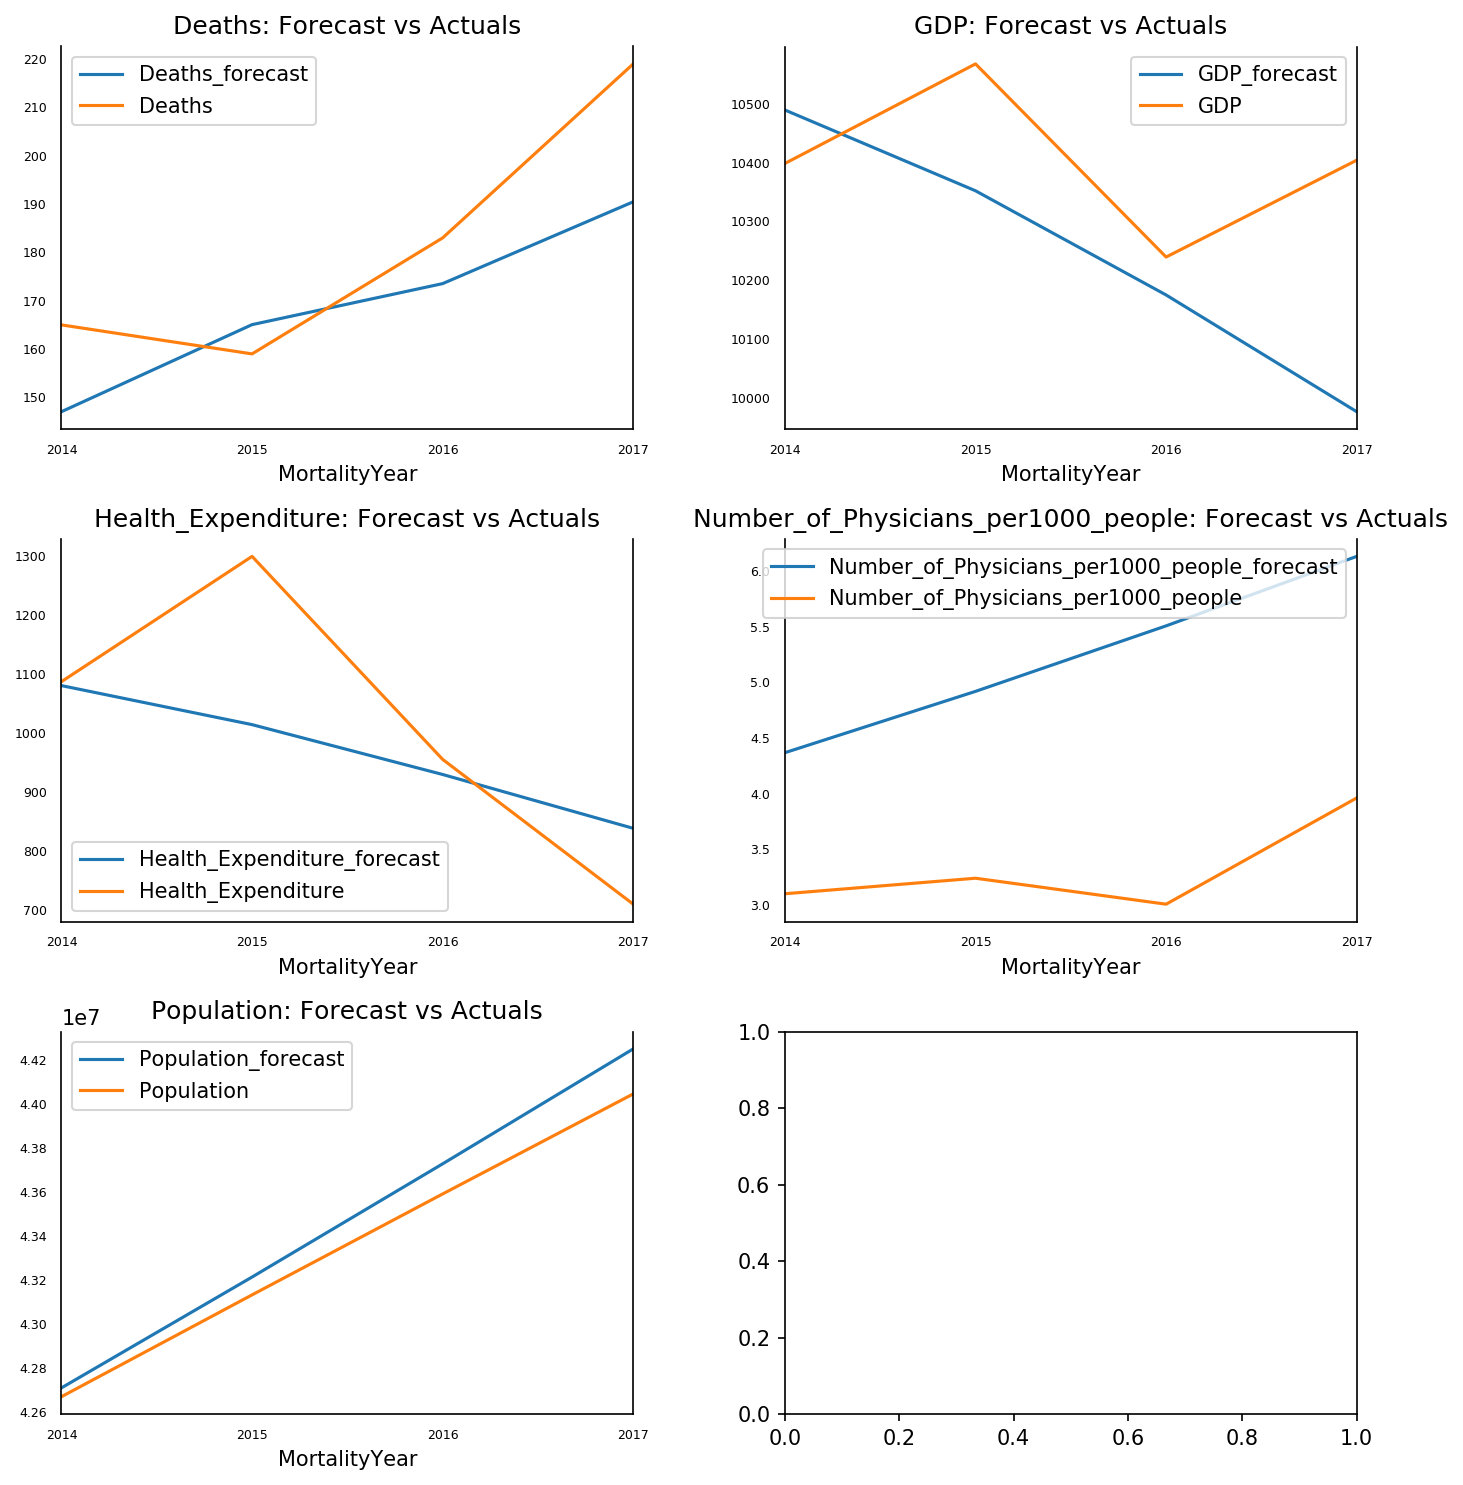

In [28]:
#Checking closeness of the actual values and forecasts

fig, axes = plt.subplots(nrows=3, ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(s.columns, axes.flatten())):
    s_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    s_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [29]:
#Plotting all actual values and the forecast values

a = s[['Deaths']]
b = s_results[['Deaths_forecast']]

source = ColumnDataSource(a)

p = figure(x_axis_type='datetime')
p.line(x='MortalityYear', y='Deaths', line_width=2, source=source, legend='Actual')

source = ColumnDataSource(b)

p.line(x='MortalityYear', y='Deaths_forecast', line_width=2, source=source, color='red', legend='Forecast')

show(p)

In [30]:
print('Forecast Accuracy of: Deaths')
accuracy_prod = forecast_accuracy(s_results['Deaths_forecast'].values, s_test['Deaths'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: GDP')
accuracy_prod = forecast_accuracy(s_results['GDP_forecast'].values, s_test['GDP'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: Health Expenditure')
accuracy_prod = forecast_accuracy(s_results['Health_Expenditure_forecast'].values, s_test['Health_Expenditure'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: Number_of_Physicians_per1000_people')
accuracy_prod = forecast_accuracy(s_results['Number_of_Physicians_per1000_people_forecast'].values, s_test['Number_of_Physicians_per1000_people'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    
print('\nForecast Accuracy of: Population')
accuracy_prod = forecast_accuracy(s_results['Population_forecast'].values, s_test['Population'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Deaths
mape   :  0.0822
me     :  -12.4733
mae    :  15.5006
mpe    :  -0.0632
rmse   :  17.7671
corr   :  0.863
minmax :  0.0819

Forecast Accuracy of: GDP
mape   :  0.0192
me     :  -154.3552
mae    :  199.8498
mpe    :  -0.0148
rmse   :  246.0681
corr   :  0.3102
minmax :  0.0191

Forecast Accuracy of: Health Expenditure
mape   :  0.1082
me     :  -47.1343
mae    :  111.3139
mpe    :  -0.0178
rmse   :  156.692
corr   :  0.8119
minmax :  0.1013

Forecast Accuracy of: Number_of_Physicians_per1000_people
mape   :  0.5775
me     :  1.9062
mae    :  1.9062
mpe    :  0.5775
rmse   :  1.9633
corr   :  0.7142
minmax :  0.3602

Forecast Accuracy of: Population
mape   :  0.0026
me     :  115605.2448
mae    :  115605.2448
mpe    :  0.0026
rmse   :  131065.2771
corr   :  0.9999
minmax :  0.0026


## Forecasts for Bronchitis

In [31]:
start = time.process_time() #To calculate the time taken to train the model

br_final = pd.DataFrame()

for c in br.CountryName.unique():
    country_final = model_forecast(br, c, 'Bronchitis')
    country_final['CountryName'] = c
    country_final['Class'] = 'Bronchitis'
    br_final = br_final.append(country_final).reset_index(drop=True)
    
br_final.rename(columns={'index': 'Year'}, inplace=True)
print("Bronchitis final dataframe created in ", time.process_time() - start, "seconds\n")
print("Year range: ", br_final.Year.unique()[0], "to", br_final.Year.unique()[23])
br_final.head(24)

Bronchitis final dataframe created in  6.1245319999999985 seconds

Year range:  1997-01-01T00:00:00.000000000 to 2020-01-01T00:00:00.000000000


,Year,Deaths,GDP,Health_Expenditure,Number_of_Physicians_per1000_people,Population,CountryName,Class
0,1997-01-01,282.000000,8543.028534,450.225150,2.839366,3.565743e+07,Argentina,Bronchitis
1,1998-01-01,282.000000,8772.063210,478.268474,3.002100,3.606346e+07,Argentina,Bronchitis
2,1999-01-01,314.000000,8381.253998,437.328304,2.834859,3.646722e+07,Argentina,Bronchitis
3,2000-01-01,217.000000,8224.112827,705.199321,3.042454,3.687079e+07,Argentina,Bronchitis
4,2001-01-01,262.000000,7776.137872,671.529439,3.231100,3.727565e+07,Argentina,Bronchitis
5,2002-01-01,217.000000,6854.294081,223.379708,2.785163,3.768175e+07,Argentina,Bronchitis
6,2003-01-01,245.000000,7380.467087,261.489665,2.767959,3.808787e+07,Argentina,Bronchitis
7,2004-01-01,200.000000,7962.412309,299.627944,3.166200,3.849197e+07,Argentina,Bronchitis
8,2005-01-01,197.000000,8577.864994,390.991101,3.210000,3.889293e+07,Argentina,Bronchitis
9,2006-01-01,154.000000,9174.502458,448.419032,2.753382,3.928988e+07,Argentina,Bronchitis


In [32]:
#Plotting 
br_list = plot_countries(br_final)

# make a grid
grid = gridplot(br_list, ncols=2, plot_width=470, plot_height=300)
show(grid)

## Forecasts for Tuberculosis

In [33]:
tu = df[df['Class'] == 'Tuberculosis']
print("Shape: ", tu.shape)
print("\nDifferent Countries: ",tu.CountryName.nunique(), "\n", tu.CountryName.unique())
tu.head()

Shape:  (195, 9)

Different Countries:  10 
 ['Argentina' 'Brazil' 'Canada' 'Colombia' 'Cuba' 'Ecuador' 'Mexico' 'Peru'
 'Puerto Rico' 'United States']


,CountryName,MortalityYear,Class,Deaths,GDP,Health_Expenditure,Number_of_Physicians_per1000_people,Population,Zone
1,Argentina,1997,Tuberculosis,144,8543.028534,450.225150,2.839366,35657429.0,SouthAmerica
3,Argentina,1998,Tuberculosis,127,8772.063210,478.268474,3.002100,36063459.0,SouthAmerica
5,Argentina,1999,Tuberculosis,154,8381.253998,437.328304,2.834859,36467218.0,SouthAmerica
7,Argentina,2000,Tuberculosis,130,8224.112827,705.199321,3.042454,36870787.0,SouthAmerica
9,Argentina,2001,Tuberculosis,125,7776.137872,671.529439,3.231100,37275652.0,SouthAmerica


In [34]:
#Checking for null values
tu.columns.isna()

array([False, False, False, False, False, False, False, False, False])

In [35]:
start = time.process_time() #To calculate the time taken to train the model

tu_final = pd.DataFrame()

for c in tu.CountryName.unique():
    country_final = model_forecast(tu, c, 'Tuberculosis')
    country_final['CountryName'] = c
    country_final['Class'] = 'Tuberculosis'
    tu_final = tu_final.append(country_final).reset_index(drop=True)
    
tu_final.rename(columns={'index': 'Year'}, inplace=True)
print("Tuberculosis final dataframe created in ", time.process_time() - start, "seconds\n")
print("Year range: ", tu_final.Year.unique()[0], "to", tu_final.Year.unique()[23])
tu_final.head(24)

Tuberculosis final dataframe created in  6.1794720000000005 seconds

Year range:  1997-01-01T00:00:00.000000000 to 2020-01-01T00:00:00.000000000


,Year,Deaths,GDP,Health_Expenditure,Number_of_Physicians_per1000_people,Population,CountryName,Class
0,1997-01-01,144.000000,8543.028534,450.225150,2.839366,3.565743e+07,Argentina,Tuberculosis
1,1998-01-01,127.000000,8772.063210,478.268474,3.002100,3.606346e+07,Argentina,Tuberculosis
2,1999-01-01,154.000000,8381.253998,437.328304,2.834859,3.646722e+07,Argentina,Tuberculosis
3,2000-01-01,130.000000,8224.112827,705.199321,3.042454,3.687079e+07,Argentina,Tuberculosis
4,2001-01-01,125.000000,7776.137872,671.529439,3.231100,3.727565e+07,Argentina,Tuberculosis
5,2002-01-01,114.000000,6854.294081,223.379708,2.785163,3.768175e+07,Argentina,Tuberculosis
6,2003-01-01,70.000000,7380.467087,261.489665,2.767959,3.808787e+07,Argentina,Tuberculosis
7,2004-01-01,100.000000,7962.412309,299.627944,3.166200,3.849197e+07,Argentina,Tuberculosis
8,2005-01-01,98.000000,8577.864994,390.991101,3.210000,3.889293e+07,Argentina,Tuberculosis
9,2006-01-01,92.000000,9174.502458,448.419032,2.753382,3.928988e+07,Argentina,Tuberculosis


In [36]:
#Plotting 
tu_list = plot_countries(tu_final)

# make a grid
grid = gridplot(tu_list, ncols=2, plot_width=470, plot_height=300)
show(grid)